# Sampling Time Comparison: N samples for 1 obs vs 1 sample for N obs

This notebook compares the sampling time for:
1. **Strategy A**: Sample N points for 1 observation
2. **Strategy B**: Sample 1 point for each of N observations

We use a simple Gaussian prior with a linear model.

In [1]:
import sys
import time
from pathlib import Path

import torch
import numpy as np
from pyro import distributions as dist

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))
from npe_pfn import TabPFN_Based_NPE_PFN

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

/home/pruhlman/miniconda3/envs/npe-fn/lib/python3.12/site-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.
/home/pruhlman/miniconda3/envs/npe-fn/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


PyTorch version: 2.6.0+cu124
Device: cpu


## Setup: Gaussian Prior + Linear Model

In [6]:
# Configuration
theta_dim = 2
obs_dim = 50
num_calibration = 100
N = 10  # Number of samples/observations to compare

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define prior: Gaussian
prior_loc = torch.zeros(theta_dim)
prior_cov = torch.eye(theta_dim)
prior = dist.MultivariateNormal(loc=prior_loc, covariance_matrix=prior_cov)

# Define linear model: y = A @ theta + b + noise
torch.manual_seed(42)
A = torch.randn(obs_dim, theta_dim)
b = torch.randn(obs_dim)
noise_std = 0.1

def simulator(theta):
    """Linear simulator: y = A @ theta + b + noise"""
    y = theta @ A.T + b + noise_std * torch.randn(theta.shape[0], obs_dim)
    return y

print(f"Prior: Gaussian({theta_dim}D)")
print(f"Model: Linear (y = A @ theta + b + noise)")
print(f"Observation dim: {obs_dim}")

Using device: cpu
Prior: Gaussian(2D)
Model: Linear (y = A @ theta + b + noise)
Observation dim: 50


## Generate Calibration Data

In [7]:
# Generate calibration data
theta_cal = prior.sample((num_calibration,))
y_cal = simulator(theta_cal)

# Move to device
theta_cal = theta_cal.to(device)
y_cal = y_cal.to(device)

print(f"Calibration data: {num_calibration} samples")
print(f"theta_cal shape: {theta_cal.shape}")
print(f"y_cal shape: {y_cal.shape}")

Calibration data: 100 samples
theta_cal shape: torch.Size([100, 2])
y_cal shape: torch.Size([100, 50])


## Initialize NPE-PFN

In [8]:
# Initialize NPE-PFN
posterior = TabPFN_Based_NPE_PFN(prior=prior)

# Append calibration data
posterior.append_simulations(theta_cal, y_cal)

print("NPE-PFN initialized and calibration data appended")

NPE-PFN initialized and calibration data appended


## Strategy A: Sample N points for 1 observation

In [9]:
# Generate 1 test observation
theta_test_single = prior.sample((1,))
y_test_single = simulator(theta_test_single).to(device)

print(f"Test observation shape: {y_test_single.shape}")
print(f"\nStrategy A: Sample {N} points for 1 observation")
print("-" * 60)

# Warm-up
_ = posterior.sample(sample_shape=torch.Size([1]), x=y_test_single)

# Time sampling N points for 1 observation
start_time = time.time()
samples_A = posterior.sample(sample_shape=torch.Size([N]), x=y_test_single)
time_A = time.time() - start_time

print(f"Time taken: {time_A:.4f} seconds")
print(f"Samples shape: {samples_A.shape}")
print(f"Time per sample: {time_A / N * 1000:.2f} ms")

Test observation shape: torch.Size([1, 50])

Strategy A: Sample 10 points for 1 observation
------------------------------------------------------------
Time taken: 8.1098 seconds
Samples shape: torch.Size([10, 2])
Time per sample: 810.98 ms


## Strategy B: Sample 1 point for N observations

In [10]:
# Generate N test observations
theta_test_multiple = prior.sample((N,))
y_test_multiple = simulator(theta_test_multiple).to(device)

print(f"Test observations shape: {y_test_multiple.shape}")
print(f"\nStrategy B: Sample 1 point for each of {N} observations")
print("-" * 60)

# Warm-up
_ = posterior.sample(sample_shape=torch.Size([1]), x=y_test_multiple[0:1])

# Time sampling 1 point for each of N observations
start_time = time.time()
samples_B = []
for y_single in y_test_multiple:
    sample = posterior.sample(sample_shape=torch.Size([1]), x=y_single.unsqueeze(0))
    samples_B.append(sample.squeeze())
samples_B = torch.stack(samples_B)
time_B = time.time() - start_time

print(f"Time taken: {time_B:.4f} seconds")
print(f"Samples shape: {samples_B.shape}")
print(f"Time per observation: {time_B / N * 1000:.2f} ms")

Test observations shape: torch.Size([10, 50])

Strategy B: Sample 1 point for each of 10 observations
------------------------------------------------------------
Time taken: 73.9022 seconds
Samples shape: torch.Size([10, 2])
Time per observation: 7390.22 ms


## Comparison

In [11]:
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"\nStrategy A: {N} samples for 1 observation")
print(f"  Total time: {time_A:.4f} seconds")
print(f"  Time per sample: {time_A / N * 1000:.2f} ms")

print(f"\nStrategy B: 1 sample for {N} observations")
print(f"  Total time: {time_B:.4f} seconds")
print(f"  Time per observation: {time_B / N * 1000:.2f} ms")

print(f"\nSpeedup factor: {time_B / time_A:.2f}x")
if time_A < time_B:
    print(f"Strategy A is {time_B / time_A:.2f}x FASTER")
else:
    print(f"Strategy B is {time_A / time_B:.2f}x FASTER")

print("\n" + "=" * 60)


COMPARISON SUMMARY

Strategy A: 10 samples for 1 observation
  Total time: 8.1098 seconds
  Time per sample: 810.98 ms

Strategy B: 1 sample for 10 observations
  Total time: 73.9022 seconds
  Time per observation: 7390.22 ms

Speedup factor: 9.11x
Strategy A is 9.11x FASTER



## Detailed Timing Breakdown

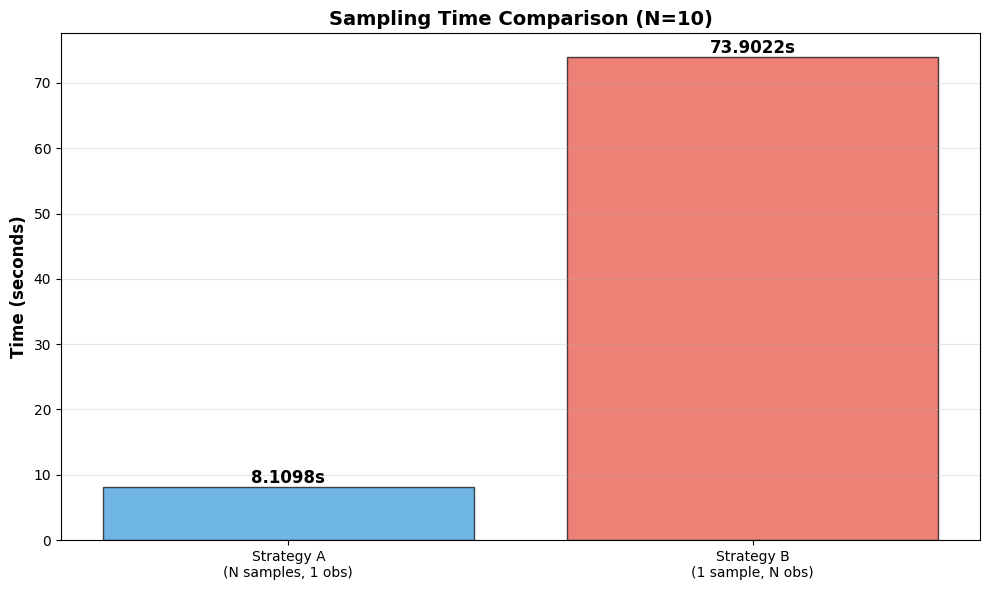


Conclusion:
For this setup, it's more efficient to sample 10 points for 1 observation
than to sample 1 point for each of 10 observations.


In [12]:
import matplotlib.pyplot as plt

# Create bar plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

strategies = ['Strategy A\n(N samples, 1 obs)', 'Strategy B\n(1 sample, N obs)']
times = [time_A, time_B]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(strategies, times, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.4f}s',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title(f'Sampling Time Comparison (N={N})', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConclusion:")
if time_A < time_B:
    print(f"For this setup, it's more efficient to sample {N} points for 1 observation")
    print(f"than to sample 1 point for each of {N} observations.")
else:
    print(f"For this setup, it's more efficient to sample 1 point for each of {N} observations")
    print(f"than to sample {N} points for 1 observation.")

## Vary N to See Scaling

In [ ]:
# Test different values of N
N_values = [10, 20, 50, 100, 200]
times_A_list = []
times_B_list = []

print("Testing different values of N...")
print("-" * 60)

for n in N_values:
    # Strategy A
    start = time.time()
    _ = posterior.sample(sample_shape=torch.Size([n]), x=y_test_single)
    t_a = time.time() - start
    times_A_list.append(t_a)
    
    # Strategy B
    y_test_n = simulator(prior.sample((n,))).to(device)
    start = time.time()
    for y_single in y_test_n:
        _ = posterior.sample(sample_shape=torch.Size([1]), x=y_single.unsqueeze(0))
    t_b = time.time() - start
    times_B_list.append(t_b)
    
    print(f"N={n:3d}: Strategy A={t_a:.4f}s, Strategy B={t_b:.4f}s, Ratio={t_b/t_a:.2f}x")

print("-" * 60)

In [ ]:
# Plot scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Absolute times
ax1.plot(N_values, times_A_list, 'o-', label='Strategy A (N samples, 1 obs)', 
         linewidth=2, markersize=8, color='#3498db')
ax1.plot(N_values, times_B_list, 's-', label='Strategy B (1 sample, N obs)', 
         linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Number of samples/observations (N)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Absolute Sampling Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Right plot: Speedup ratio
ratios = [t_b / t_a for t_a, t_b in zip(times_A_list, times_B_list)]
ax2.plot(N_values, ratios, 'o-', linewidth=2, markersize=8, color='#2ecc71')
ax2.axhline(y=1, color='red', linestyle='--', label='Equal performance', alpha=0.5)
ax2.set_xlabel('Number of samples/observations (N)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Speedup (Strategy B / Strategy A)', fontsize=12, fontweight='bold')
ax2.set_title('Performance Ratio', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()